In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt
import requests
from pymongo import MongoClient
from PIL import Image
import io
from twilio.rest import Client
import keys
from keras.preprocessing import image
from PIL import Image
import cv2
import gridfs
import warnings
import time
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
IMAGE_SIZE = [224, 224]

In [3]:
#Give dataset path
train_path = '../data/train/'
test_path = '../data/test/'
validation_path = "../data/val/"

In [41]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [42]:
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>

In [43]:
for layer in vgg.layers:
  layer.trainable = False

In [52]:
topModel = vgg.output
topModel = Flatten(name="flatten")(topModel)
topModel = Dense(4096,activation="relu")(topModel)
topModel = Dense(1072,activation="relu")(topModel)
outputLayer = Dense(2,activation="softmax")(topModel)


model = Model(inputs=vgg.input, outputs=outputLayer)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [37]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [53]:

optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

In [6]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [4]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [7]:
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2329 images belonging to 2 classes.


In [8]:
class_names = ['Accident', 'Non accident']

In [9]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 423 images belonging to 2 classes.


In [10]:
validation_set = test_datagen.flow_from_directory(validation_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 98 images belonging to 2 classes.


In [156]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint



checkpoint = ModelCheckpoint(filepath='mymodel.h5', monitor="val_accuracy",
                               verbose=2, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit(
  train_set,
  validation_data=validation_set,
  epochs=20,
  callbacks=callbacks)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/20
73/73 [==============================] - 588s 7s/step - loss: 0.5077 - accuracy: 0.7776 - val_loss: 0.4531 - val_accuracy: 0.8265

Epoch 00001: val_accuracy improved from -inf to 0.82653, saving model to mymodel.h5
Epoch 2/20
73/73 [==============================] - 448s 6s/step - loss: 0.4052 - accuracy: 0.8059 - val_loss: 0.4549 - val_accuracy: 0.8367

Epoch 00002: val_accuracy improved from 0.82653 to 0.83673, saving model to mymodel.h5
Epoch 3/20
73/73 [==============================] - 465s 6s/step - loss: 0.3280 - accuracy: 0.8519 - val_loss: 0.4818 - val_accuracy: 0.7653

Epoch 00003: val_accuracy did not improve from 0.83673
Epoch 4/20
73/73 [==============================] - 471s 6s/step - loss: 0.3359 - accuracy: 0.8570 - val_loss: 0.5322 - val_accuracy: 0.7653

Epoch 00004: val_accuracy did not improve from 0.83673
Epoch 5/20
73/73 [==============================] - 472s 6s/step - loss: 0.3369 - accuracy: 0.8497 - val_loss: 0.4916 - val_accuracy: 0.8061

Epoch 000

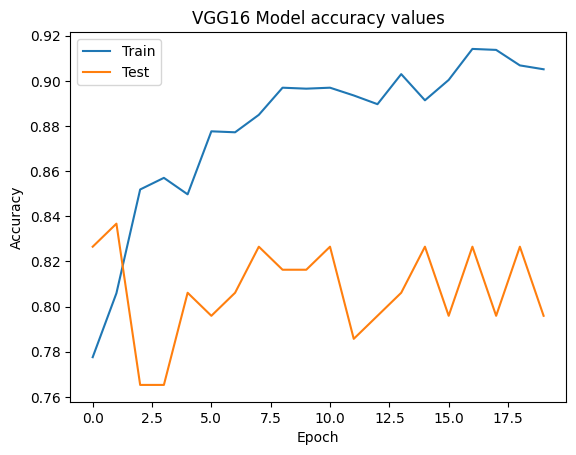

In [157]:
_# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('VGG16 Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


Found 423 files belonging to 2 classes.


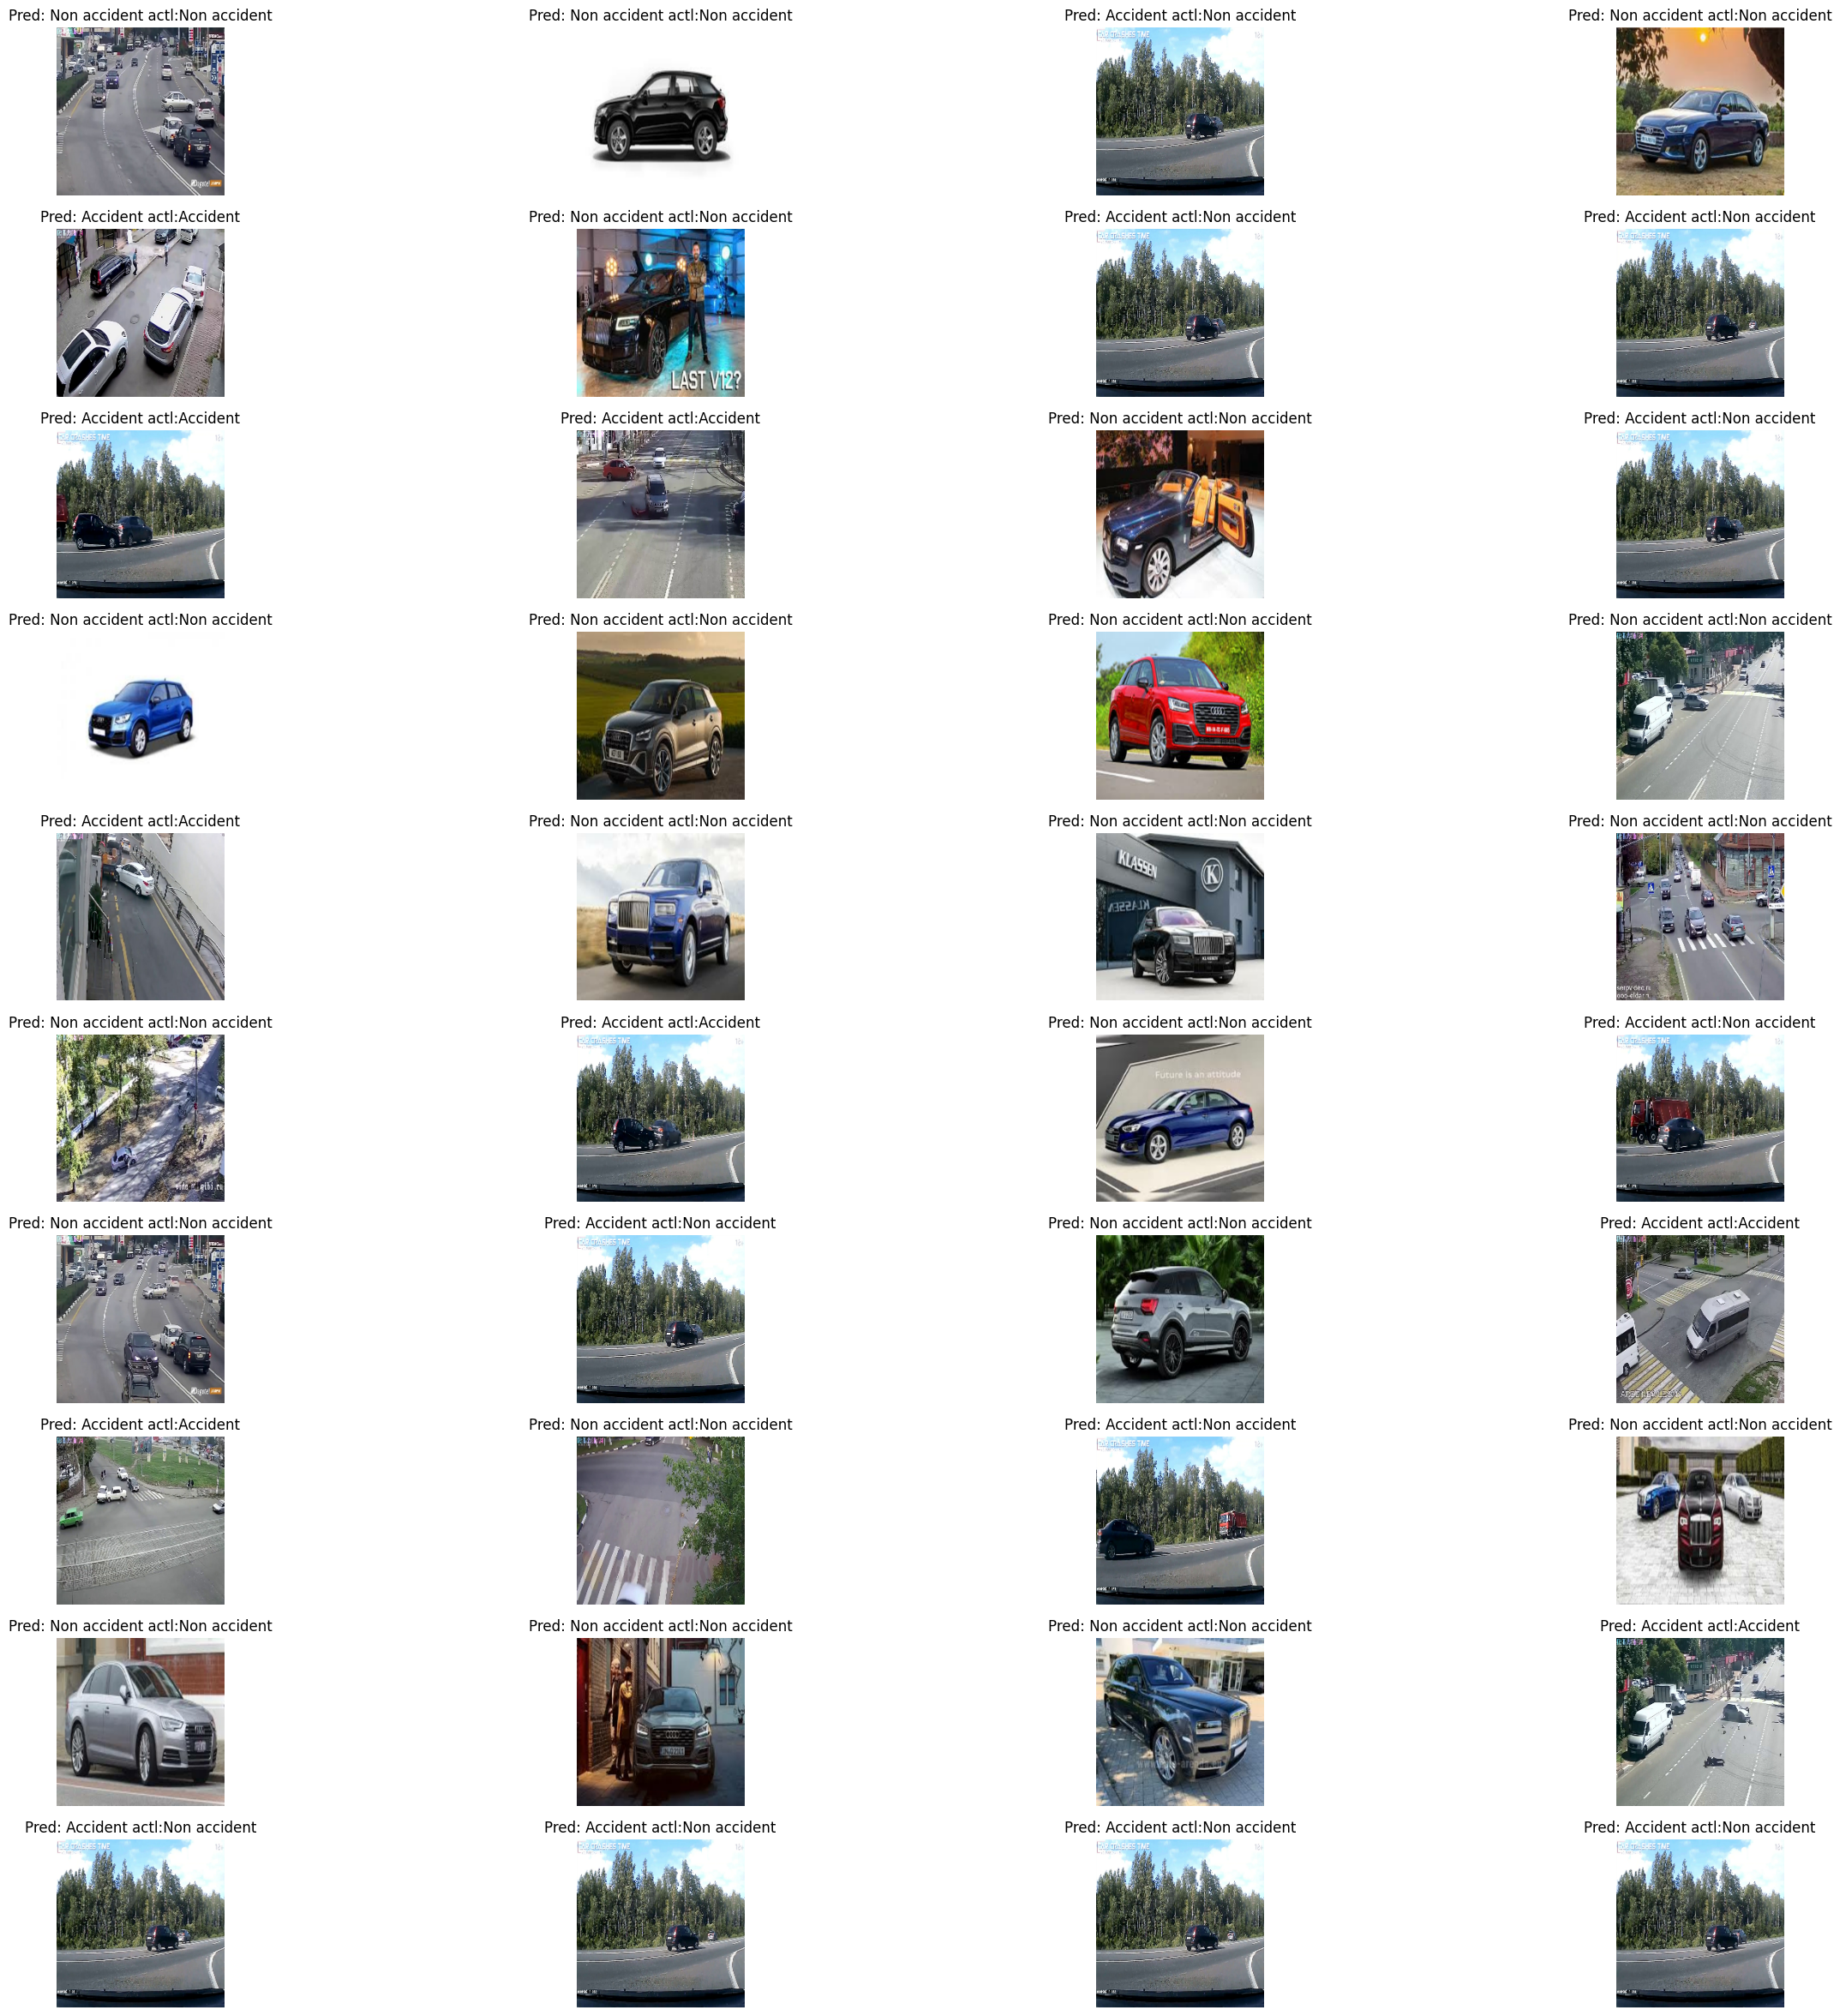

In [158]:
testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../data/test',
    seed=42,
    image_size= (224,224),
    batch_size=100,
    color_mode='rgb'
)

AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in testing_data.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

In [2]:
loaded_model = tf.keras.models.load_model("mymodel.h5")
loaded_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Found 423 files belonging to 2 classes.
The accuracy score is  0.71
The f1 score of the model is  [0.56716418 0.78195489]


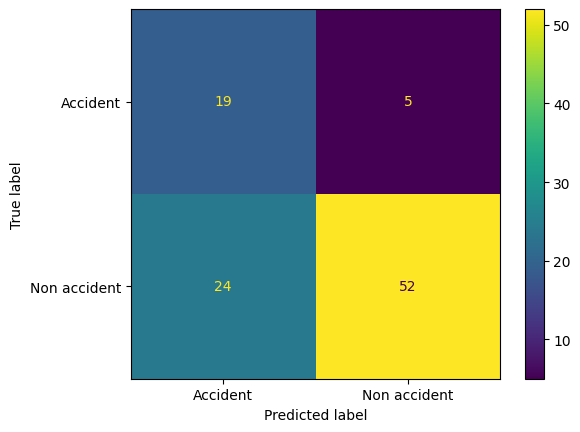

In [22]:
# model parameters confusion matrix, F1 score
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score

testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../data/test',
    seed=42,
    image_size= (224,224),
    batch_size=100,
    color_mode='rgb'
)


for images, labels in testing_data.take(1):
    predictions = loaded_model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    cm = confusion_matrix(labels,prdlbl)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
    disp.plot()

    ac = accuracy_score(labels, prdlbl)
    print("The accuracy score is ", ac)
    
    f1 = f1_score(labels, prdlbl, average=None)
    print("The f1 score of the model is ", f1)

## Updating the database

In [3]:
#making a post request to nosql database to store image

def addAccidentImage():

    client = MongoClient()
    db = client.accidentImages
    
    fileLocation = "./frames/frame.jpg"
    fileData = open(fileLocation,"rb")
    data = fileData.read()

    fs = gridfs.GridFS(db)
    upload_id = fs.put(data, filename="acc_image.jpg")
    print(upload_id)
    return upload_id

# making a post request to update sql database

def addAccident():
  image_id = addAccidentImage()
  try:
    API_ENDPOINT = "http://localhost:8000/api/createaccident/"

    data = {
      "latitude":12.92396327400973,  
      "longitude":77.49898012557998,
      "image":image_id,
    }
    
    r = requests.post(url= API_ENDPOINT, data = data, verify=False)

    #extracting the response text
    print("The response returned is ", r.text)
  except Exception as e:
         print(e)



## Detecting accident from image

In [4]:


def predict_accident(filename):
    img_width, img_height = 224, 224
    img = image.load_img((filename), target_size = (img_width, img_height, 3))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    
    prediction = loaded_model.predict(img)
    predicted_class = np.argmax(prediction)
    #if(predicted_class==1):
        #print("No accident")
    if(predicted_class==0):
        if(prediction[0][predicted_class]>0.8):  
            dis = plt.imread(filename)
            plt.axis("off") 
            plt.imshow(dis)
            print("Accident")
            print("\n Predicted with accuracy " + str(prediction[0][predicted_class])+" \n")
            return 1
    return 0

## Alerting the Emergency services

In [5]:


def callEmergencyServices():
       client = Client(keys.acount_sid,keys.auth_token)

       call = client.calls.create(
            url='http://demo.twilio.com/docs/voice.xml',
            to="+917829808808",
            from_= keys.twilio_number
       )
       print(call.sid)

## Detecting accident from video

In [6]:
import cv2;

def detectAccidentFromVideo(path):
    video = cv2.VideoCapture(path)
    success=1
    count = 0
    while(success):
        count+=1
        success, image = video.read()
        cv2.imwrite("./frames/frame.jpg",image)
        ret = predict_accident("./frames/frame.jpg")
        if(ret==1):
          callEmergencyServices()
          addAccident()
          break

## Checking the CCTV Footage

Accident

 Predicted with accuracy 0.9349852 

CA1e093994a8737eee039312662a0d9348
63fc4525c1aba621ce770164
The response returned is  "success"


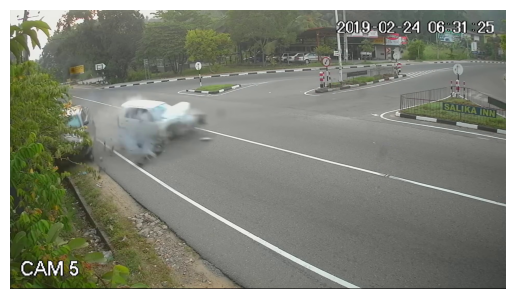

In [10]:
detectAccidentFromVideo("./acc_vid.mp4")